In [2]:
import xarray as xr
import sacpy as scp
import matplotlib.pyplot as plt
import numpy as np

In [3]:
time1 = "1980-01"
time2 = "2018-12"
slp = xr.open_dataset("../../DATA/slp.mon.mean.2x2.nc")['slp']
slp_rg = slp.loc[time1:time2,0:60,120:280]
slp_rga = scp.get_anom(slp_rg)
slp = slp.loc[time1:time2, 10:55, 130:250]
slpa = scp.get_anom(slp)
coslat = np.cos(np.deg2rad(slpa.lat))
wgts = np.sqrt(coslat).to_numpy()[...,np.newaxis]
time1 = "1980-01"
time2 = "2018-12"
slp = xr.open_dataset("../../DATA/slp.mon.mean.2x2.nc")['slp']
slp_rg = slp.loc[time1:time2,0:60,120:280]
slp_rga = scp.get_anom(slp_rg)
slp = slp.loc[time1:time2, 10:55, 130:250]
slpa = scp.get_anom(slp)
lhf = xr.open_dataset("../../DATA/ncep2_180x90/lhtfl.sfc.mon.mean.nc")['lhtfl']
lhf = -lhf.loc[time1:time2, 0:60,120:280]
lhfa = scp.get_anom(lhf)

In [4]:
# 计算PMM
# old def
time1 = "1980-01"
time2 = "2018-12"
sst = xr.open_dataset("../../DATA/HadISST_sst_2x2.nc")['sst']
sst_pt = sst.loc[time1:time2,-30:30,120:280]
sst_r = sst.loc[time1:time2, 0:60,120:280]
sst_ra = scp.get_anom(sst_r)
sst_pt = scp.get_anom(sst_pt)
sst = sst.loc[time1:time2, -20:30, 150:275]
ssta = scp.get_anom(sst)
eof1 = scp.EOF(ssta)
eof1.solve()
pmm_pc = -eof1.get_pc(npt=3)[1]
pmm_pt = -eof1.get_pt(npt=3)[1]

ssta_lr = scp.LinReg(pmm_pc,sst_pt)
pmm_region_xr = xr.DataArray(ssta_lr.slope,coords={"lat":sst_pt.lat,"lon":sst_pt.lon})
pmm_region_xr  = pmm_region_xr  > 0.17
pmm_region_xr [pmm_region_xr.lat<=5] = False 
pmm_region_xr[pmm_region_xr.lat==29] = False
pmm_region_xr = pmm_region_xr.loc[0:30]

In [5]:
uw = xr.open_dataset("../../DATA/ncep2_180x90/uwnd.10m.mon.mean.nc")['uwnd']
vw = xr.open_dataset("../../DATA/ncep2_180x90/vwnd.10m.mon.mean.nc")['vwnd']

uw,vw = map(lambda data: data.loc[time1:time2,10,0:60,120:280],[uw,vw])
uw['time'] = sst.time
vw['time'] = sst.time
lhfa['time'] = sst.time
uwa, vwa = map(scp.get_anom,[uw,vw])

In [6]:
import numpy as np
coslat = np.cos(np.deg2rad(slpa.lat))
wgts = np.sqrt(coslat).to_numpy()[...,np.newaxis]
eof = scp.EOF(slpa,weights=wgts)
# eof = scp.EOF(slpa)
eof.solve()
pc = -eof.get_pc(npt=6)
pt = -eof.get_pt(npt=6)
for i in [3,5]:
    pc[i] = -pc[i]
    pt[i] = -pt[i]




var_pc = eof.get_varperc()[:6]
var_pc

array([0.43134657, 0.15187496, 0.12987028, 0.07461009, 0.05183533,
       0.03344076], dtype=float32)

In [7]:
import cartopy.crs as ccrs
from matplotlib import colors
import numpy as np
import cmaps
import sacpy.Map
from matplotlib.ticker import MultipleLocator


def mask(reg,pthres=0.05):
    if isinstance(reg.slope,xr.DataArray):
        reg.slope = xr.where(reg.p_value < pthres,reg.slope,np.NAN)
    else:
        reg.slope[reg.p_value>=pthres]=np.NaN


def mask_wind(reg1,reg2,con="or",pthres=0.05):
    if isinstance(reg1.slope,xr.DataArray):
        reg1.slope = xr.where((reg1.p_value.to_numpy() < pthres) | (reg2.p_value.to_numpy() < pthres),reg1.slope,np.NAN)
        reg2.slope = xr.where((reg1.p_value.to_numpy() < pthres) | (reg2.p_value.to_numpy() < pthres),reg2.slope,np.NAN)


abcd = ['a','b','c','d']
cmap = colors.ListedColormap(['blue',"none", 'red'])
bounds=[-1e10,-1e-5,1e-5,1e10]
norm = colors.BoundaryNorm(bounds, cmap.N)

/var/folders/5k/c05qgth15439s3q6z8pt7bkm0000gn/T/ipykernel_1512/927805431.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("./pic/Fig7.png",dpi=300)


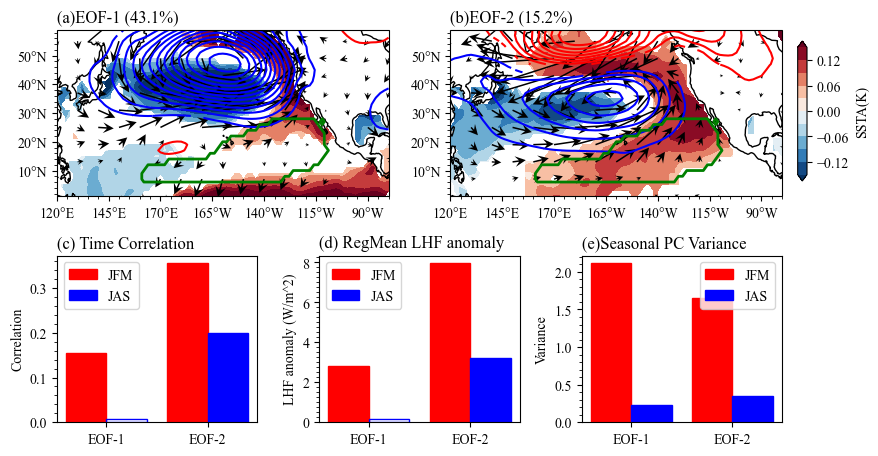

In [9]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=[(12+2)/1.5,7/1.5])

gs = GridSpec(2, 7, figure=fig)
ax1 = fig.add_subplot(gs[0, :3],projection=ccrs.PlateCarree(central_longitude=180))
ax2 = fig.add_subplot(gs[0, 3:-1],projection=ccrs.PlateCarree(central_longitude=180))
ax3 = fig.add_subplot(gs[1,0:2 ])
ax4 = fig.add_subplot(gs[1, 2:4])
ax5 = fig.add_subplot(gs[1, 4:-1])

ax_ls = [ax1,ax2,ax3,ax4,ax5]

for i in range(2):
    ax = ax_ls[i]
    slp_reg = scp.LinReg(pc[i],slp_rga)
    ssta_reg = scp.LinReg(pc[i][:-2],sst_ra[2:])
    lhf_reg = scp.LinReg(pc[i],lhfa)
    u_reg = scp.LinReg(pc[i],uwa)
    v_reg = scp.LinReg(pc[i],vwa)
    mask(slp_reg)
    mask(lhf_reg)
    mask(ssta_reg,pthres=0.1)
    mask_wind(u_reg,v_reg)

    m = ax.scontour(slp_rga.lon,slp_rga.lat,slp_reg.slope,transform=ccrs.PlateCarree(),cmap=cmap,norm=norm,levels=np.arange(-5.6,4,0.4))
    # n = ax.scontourf(lhfa.lon,lhfa.lat,lhf_reg.slope)
    n = ax.scontourf(sst_r.lon,sst_r.lat,ssta_reg.slope,levels=np.arange(-0.15,0.151,0.03),cmap="RdBu_r")
    q = ax.squiver(uwa.lon,uwa.lat,u_reg.slope,v_reg.slope,stepx=5,stepy=3,scale=10,headwidth=7,headlength=7)
    ax.scontour(pmm_region_xr.lon,pmm_region_xr.lat,pmm_region_xr,levels=[0.5],colors="green",linewidths=2)
    # ax.sig_plot(sst_r.lon,sst_r.lat,ssta_reg.p_value,color="green")
    ax.init_map()
    ax.set_title("({})EOF-{:} ({:.1f}%)".format(abcd[i],i+1,var_pc[i]*100),fontsize=12,loc="left")
ax_cb = fig.add_axes([0.86,0.6,0.01,0.3])
cb = fig.colorbar(n,cax=ax_cb,orientation="vertical", spacing="proportional")
cb.set_label("SSTA(K)")
# ==============================================================================================================
colors = {'JFM':'red', 'JAS':'blue'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
y1 = [0.15375493, 0.35488144]
y2 = [0.00702576, 0.19850722]
x0 = np.array([0,1])
wid = 0.2
ax = ax_ls[2]
col1 = ['red','red']
col2 = ['none','blue']
ax.bar(x0-wid,y1,width=wid*2,color=col1,edgecolor="red",label="JFM")
ax.bar(x0+wid,y2,width=wid*2,color=col2,edgecolor="blue",label="JAS")
ax.set_xticks(x0)
xticks = ["EOF-{}".format(i+1) for i in x0]
# xticks[-1] = "Sum"
ax.set_xticklabels(xticks)
ax.legend(handles,labels)
ax.set_title("(c) Time Correlation",loc='left')
ax.set_ylabel("Correlation")
ax.yaxis.set_minor_locator(MultipleLocator(0.02))

# ==============================================================================================================
y1 = [2.83306074, 7.94419861]
y2 = [0.15868577, 3.20088291]
x0 = np.array([0,1])
# wid = 0.2
ax = ax_ls[3]
col1 = ['red','red']
col2 = ['none','blue']
ax.bar(x0-wid,y1,width=wid*2,color=col1,edgecolor="red",label="JFM")
ax.bar(x0+wid,y2,width=wid*2,color=col2,edgecolor="blue",label="JAS")
ax.set_xticks(x0)
xticks = ["EOF-{}".format(i+1) for i in x0]
# xticks[-1] = "Sum"
ax.set_xticklabels(xticks)
ax.legend(handles,labels)
ax.set_title("(d) RegMean LHF anomaly",loc="left")
ax.set_ylabel("LHF anomaly (W/m^2)")
ax.yaxis.set_minor_locator(MultipleLocator(0.25))

# ==============================================================================================================

y1 = [2.111663 , 1.6581789]
y2 = [0.23429489, 0.34731388]
x0 = np.array([0,1])
# wid = 0.15
ax = ax_ls[4]
col1 = ['red','red']
col2 = ['blue','blue']
ax.bar(x0-wid,y1,width=wid*2,color=col1,edgecolor="red",label="JFM")
ax.bar(x0+wid,y2,width=wid*2,color=col2,edgecolor="blue",label="JAS")
ax.set_xticks(x0)
xticks = ["EOF-{}".format(i+1) for i in x0]
ax.set_xticklabels(xticks)
ax.legend(handles,labels)
ax.set_title("(e)Seasonal PC Variance",loc='left')
ax.set_ylabel("Variance")
ax.yaxis.set_minor_locator(MultipleLocator(0.1))

# ==============================================================================================================

fig.set_tight_layout(tight=True)
plt.savefig("./pic/Fig7.png",dpi=300)